# Packages

## Global Packages

In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [23]:
import sys
import json
import wave
import time
import pyaudio
import librosa
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Constants

In [26]:
SEED = 42
BATCH_SIZE = 32
SAMPLE_RATE = 16000
VALIDATION_SPLIT = 0.2

# Path to the datasets

The dataset's audio clips are of 6 classes and stored in 6 folders corresponding to each speech command: 
- `ddyo`- `kkono` - `mu maaso` - `emabega` - `yimirira` - `unknown`

# Labels

In [28]:
def list_directory_contents(directory, label):
    contents = np.array(tf.io.gfile.listdir(str(directory)))
    print(f'{label} commands labels: {contents}')
    return contents

In [29]:
train_commands = list_directory_contents(train_data_dir, 'Train')
test_commands = list_directory_contents(test_data_dir, 'Test')

Train commands labels: ['gaali' 'no_gaali']
Test commands labels: ['gaali' 'no_gaali']


# Load sample audio files

In [30]:
gaali_file_path = os.path.join(train_data_dir, 'gaali', 'gaali_001.wav')
no_gaali_file_path = os.path.join(train_data_dir, 'no_gaali', 'no_gaali_001.wav')

file_paths = [gaali_file_path, no_gaali_file_path]

# Dataset Preparaption

## Train and validation Datasets

In [31]:
# Function to create train and validation audio datasets

def create_train_audio_dataset(data_dir, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, seed=SEED, output_sequence_length=SAMPLE_RATE):
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=batch_size,
        validation_split=validation_split,
        seed=seed,
        output_sequence_length=output_sequence_length,
        subset='both'
    )

    label_names = np.array(train_ds.class_names)

    def squeeze(audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels

    train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
    val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

    for example_audio, example_labels in train_ds.take(1):
        print(example_audio.shape)
        print(example_labels.shape)
    
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, label_names

In [32]:
train_ds, val_ds, label_names = create_train_audio_dataset(train_data_dir)

Found 5019 files belonging to 2 classes.
Using 4016 files for training.
Using 1003 files for validation.
(32, 16000)
(32,)


## Test dataset

In [33]:
# Function to create test audio dataset

def create_test_audio_dataset(data_dir, batch_size=BATCH_SIZE, output_sequence_length=SAMPLE_RATE):
    test_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=batch_size,
        validation_split=None,
        seed=0,
        output_sequence_length=output_sequence_length,
        shuffle=False
    )

    def squeeze(audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels

    test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

    for example_audio, example_labels in test_ds.take(1):
        print(example_audio.shape)
        print(example_labels.shape)

    test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

    return test_ds

In [34]:
test_ds = create_test_audio_dataset(test_data_dir)

Found 611 files belonging to 2 classes.


(32, 16000)
(32,)


# Feature Extraction

In [35]:
# Function to get mel spectrogram
def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=128):
    stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=sample_rate
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.reshape(mel_spectrogram, (-1, 124, 128, 1))

    return mel_spectrogram

In [36]:
# Function to create mel spectrogram dataset
def preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds):
    def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=128):
        stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(stft)
        mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=n_mels,
            num_spectrogram_bins=spectrogram.shape[-1],
            sample_rate=sample_rate
        )
        mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
        mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
        mel_spectrogram = tf.reshape(mel_spectrogram, (-1, 124, 128, 1))

        return mel_spectrogram

    def make_mel_spec_ds(ds):
        return ds.map(lambda x, y: (get_mel_spectrogram(x), y), tf.data.AUTOTUNE)

    train_mel_spec_ds = make_mel_spec_ds(train_ds)
    val_mel_spec_ds = make_mel_spec_ds(val_ds)
    test_mel_spec_ds = make_mel_spec_ds(test_ds)

    train_mel_spec_ds = train_mel_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_mel_spec_ds = val_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_mel_spec_ds = test_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds

In [37]:
train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds = preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds)

## Shape consistency

In [38]:
print(train_mel_spec_ds.element_spec)
print(val_mel_spec_ds.element_spec)
print(test_mel_spec_ds.element_spec)

(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Model 1

### Input shape 

In [39]:
example_spectrograms = next(iter(train_mel_spec_ds))[0]
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)
print(f'Labels {label_names}')

Input shape: (124, 128, 1)
Labels ['gaali' 'no_gaali']


In [40]:
# Model artitecture 1
def model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax')
    ])

    return model

model = model(input_shape, num_labels)

### Model Architecture

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 124, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,922 (445.01 KB)

 Trainable params: 113,922 (445.01 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the model

In [42]:
Epochs = 50
patience = 10
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [43]:
# Function to compile and train the model
def compile_and_train_model(model, train_ds, val_ds, learning_rate=learning_rate):
    try:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        history = model.fit(train_ds, validation_data=val_ds, epochs=Epochs)
        return history
    except Exception as e:
        print(f"An error occurred during model compilation and training: {str(e)}")


In [44]:
history = compile_and_train_model(model, train_mel_spec_ds, val_mel_spec_ds)

Epoch 1/50


126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.6234 - loss: 0.7552 - val_accuracy: 0.8614 - val_loss: 0.3477
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.8500 - loss: 0.3522 - val_accuracy: 0.9282 - val_loss: 0.2106
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.8934 - loss: 0.2623 - val_accuracy: 0.9422 - val_loss: 0.1823
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.9354 - loss: 0.1852 - val_accuracy: 0.9541 - val_loss: 0.1394
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.9516 - loss: 0.1383 - val_accuracy: 0.9591 - val_loss: 0.1399
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 33s 262ms/step - accuracy: 0.9611 - loss: 0.1220 - val_accuracy: 0.9601 - val_loss: 0.1277
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.9489 - loss: 0.1388 - val_accuracy: 0.9661 - val_loss: 0.1211
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9649 - loss: 0.1058 - val

### Plot Accuracy and Loss

In [ ]:

# Function to plot the training history
def plot_training_history(history):
    try:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the training history: {str(e)}")

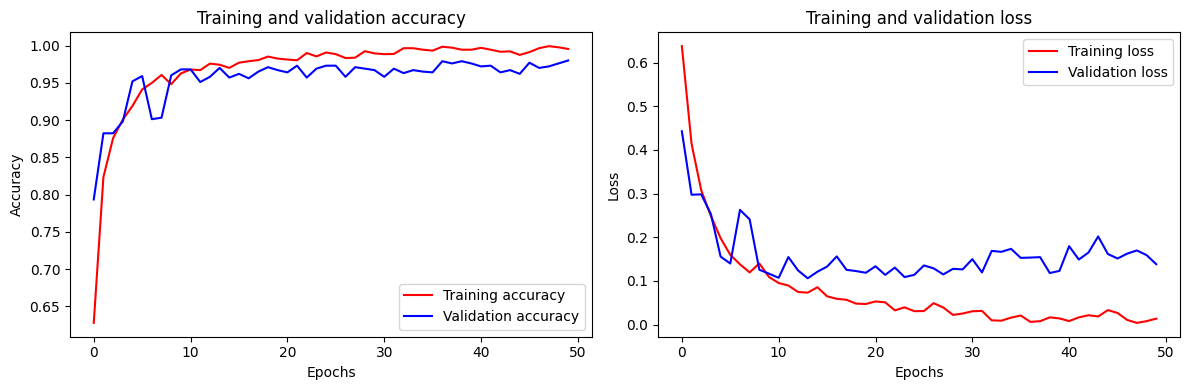

In [ ]:
plot_training_history(history)

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
# Function to evaluate the model on the test dataset
def evaluate_model(model, test_ds):
    try:
        y_true = []
        y_pred = []
        for audio, labels in test_ds:
            predictions = model.predict(audio, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(tf.argmax(predictions, axis=1).numpy())

        loss, accuracy = model.evaluate(test_ds, verbose=0)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"Test accuracy:      {int(accuracy * 100)}%")
        print(f"Test loss:          {loss}")
        print(f"Precision:          {precision}")
        print(f"Recall:             {recall}")
        print(f"F1-score:           {f1}")
    except Exception as e:
        print(f"An error occurred during model evaluation: {str(e)}")

In [ ]:
evaluate_model(model, test_mel_spec_ds)

Test accuracy:      97%
Test loss:          0.10033213347196579
Precision:          0.977009383550324
Recall:             0.9769230769230769
F1-score:           0.9769079481219657


## Confusion matrix

In [ ]:
y_pred = model.predict(test_mel_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mel_spec_ds.map(lambda s,lab: lab)), axis=0)
label_names_slice = ['gaali', 'no_gaali']

11/11 [==============================] - 1s 77ms/step


In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_names):
    try:
        confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mtx,
                    xticklabels=label_names,
                    yticklabels=label_names,
                    annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the confusion matrix: {str(e)}")

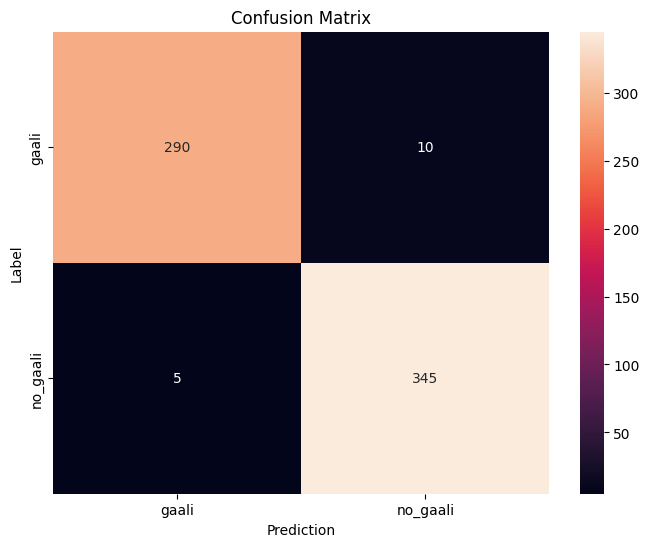

In [ ]:
plot_confusion_matrix(y_true, y_pred, label_names_slice)

## save the Keras model

In [ ]:
KERAS_MODEL_PATH = "model/wakeword_model_2.keras"

In [ ]:
model.save(KERAS_MODEL_PATH)

## Size of the keras model

In [ ]:
# Function to get the file size
def get_and_convert_file_size(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
keras_model_size = get_and_convert_file_size(KERAS_MODEL_PATH, 'MB')

File size: 1.352 Megabytes


## TFLite Model for model

In [ ]:
tflite_model_path = 'model/wakeword_model_2.tflite'

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmph41vi2bh\assets


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmph41vi2bh\assets


In [ ]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [ ]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 128   1]


In [ ]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 2]


In [ ]:
# Prepare the test dataset 
test_mel_spec_ds = test_mel_spec_ds.unbatch().batch(1)

In [ ]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 97%


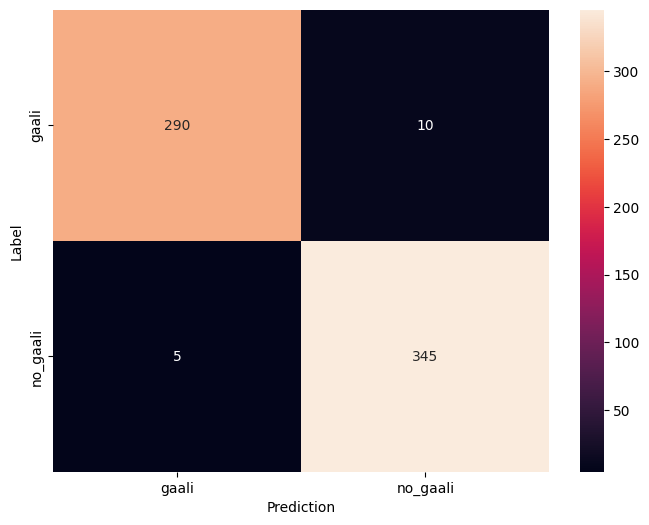

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
get_and_convert_file_size(tflite_model_path, "KB")

File size: 449.48 Kilobytes


## Quntized model

In [ ]:
quantized_tflite_model_path = 'model/Quantized_wakeword_model_2.tflite'

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open(quantized_tflite_model_path, 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmpslh54i9i\assets


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmpslh54i9i\assets


In [ ]:
get_and_convert_file_size(quantized_tflite_model_path, "KB")

File size: 120.742 Kilobytes


In [ ]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.9769230769230769


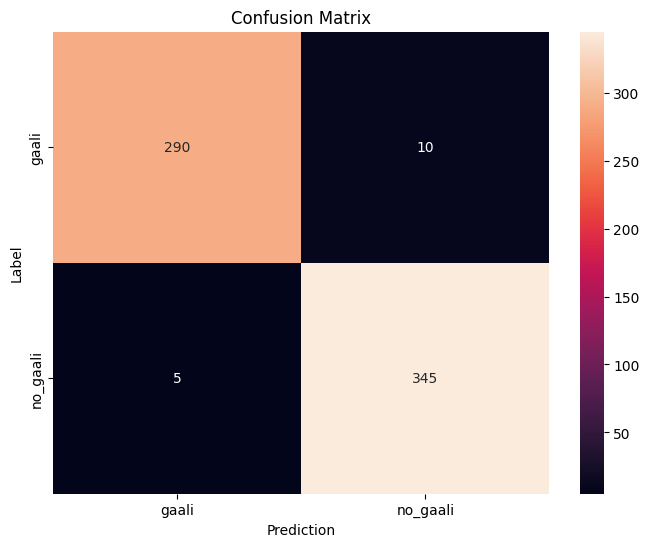

In [ ]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 97%


# Inference

## Loading the model

In [ ]:
try:
    model = tf.keras.models.load_model('model/wakeword_model_2.keras')
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading model: ", e)

Model loaded successfully.


## Record and return audio file

In [ ]:
def record_audio(filename, duration, rate=16000, channels=1, chunk_size=1024):
    p = pyaudio.PyAudio()

    # open stream
    stream = p.open(format=pyaudio.paInt16,
                    channels=channels,
                    rate=rate,
                    input=True,
                    frames_per_buffer=chunk_size)

    print("Recording...")

    frames = []

    # record for duration
    for i in range(0, int(rate / chunk_size * duration)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("Finished recording.")

    # stop and close stream
    stream.stop_stream()
    stream.close()

    # terminate pyaudio object
    p.terminate()

    # save audio file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()

    return filename

In [ ]:
# Function to print audio properties
def print_audio_properties(file_path):
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist.")
        return

    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        with wave.open(file_path, 'rb') as audio:
            num_channels = audio.getnchannels()
            frame_rate = audio.getframerate()
            num_frames = audio.getnframes()
            duration = num_frames / float(frame_rate)

            print(f"\nAudio Properties for {os.path.basename(file_path)}")
            print(f"Number of channels:  {num_channels}")
            print(f"Sample rate (Hz):    {sample_rate}")
            print(f"Number of frames:    {num_frames}")
            print(f"Duration (s):        {duration}")
            print()
        
        # Play the audio files
        audio = Audio(file_path)
        display(audio)
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
    return

## Feactures

In [ ]:
FRAME_LENGTH = 255
FRAME_STEP = 128
N_MELS = 128

In [ ]:
def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    stft = tf.signal.stft(waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=sample_rate
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.reshape(mel_spectrogram, (-1, 124, 128, 1))

    return mel_spectrogram

## Labels

In [ ]:
# Function to get the labels
def get_label_names():
    label_names = ['gaali', 'no_gaali']
    return label_names


## Prediction

In [ ]:
def predict_audio(file_path, model, sample_rate):
    x = tf.io.read_file(str(file_path))
    x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_mel_spectrogram(x, sample_rate)

    max_frames = 124
    pad_size = max_frames - x.shape[1]
    if pad_size > 0:
        x = tf.pad(x, [[0, 0], [0, pad_size], [0, 0], [0, 0]])
    else:
        x = x[:, :max_frames, :, :]

    predictions = model.predict(x)
    predicted_label_index = tf.argmax(predictions[0])
    label_names = get_label_names()
    predicted_label = label_names[predicted_label_index]

    return predicted_label, tf.nn.softmax(predictions[0])[predicted_label_index]

In [ ]:
audio_file = record_audio('output.wav', 2)

Recording...
Finished recording.


In [ ]:
# Print audio properties
print_audio_properties(audio_file)


Audio Properties for output.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    31744
Duration (s):        1.984



In [ ]:

predicted_label, probability = predict_audio(audio_file, model, SAMPLE_RATE)
print(f"Predicted label: {predicted_label}, Probability: {probability}")

1/1 [==============================] - 0s 135ms/step
Predicted label: no_gaali, Probability: 0.6415745615959167
